# Classifying the Origin of Names
* Classifying names into one of 18 origin laguages

## Summary:
**Dataset:** Names and their corresponding language origins  
**Model:** Character-level Recurrent Neural Network which classifies names by their language origin  
**Particulars:** Words and characters tokenization, neural-network with embedding and recurrent layers, softmax output  

## Table of Contents:
* Section 1 - Data Unpacking and Restructuring
* Section 2 - Preprocessing Inputs (Names)
* Section 3 - Preprocessing Labels (Origins)
* Section 4 - Generating Model and Training
* Section 5 - Final Model and Results

In [ ]:
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from skopt import BayesSearchCV
from skopt.space import Integer
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
print("Python version:", platform.python_version())

Python version: 3.10.12


# Section 1 - Data Unpacking and Restructuring

In [ ]:
# Importing zipped text files containing names of different origins

file = !ls data.zip
if file[0] != "data.zip":
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip

--2023-10-29 20:50:05--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.35.25, 13.35.35.55, 13.35.35.91, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.35.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.01MB/s    in 1.4s    

2023-10-29 20:50:07 (2.01 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [ ]:
# Displaying the contents inside the files
open("data/names/English.txt").readlines(30)

['Abbas\n', 'Abbey\n', 'Abbott\n', 'Abdi\n', 'Abel\n', 'Abraham\n']

In [ ]:
# Looping though the imported files to generate a list of names and a corresponding list origins

data = []

# Looping through imported text files
for filename in glob("data/names/*.txt"):
    # Extracting origin from the file names
    origin = filename.split("/")[-1].split(".txt")[0]

    # Extracting the contents of the file
    names = open(filename).readlines()

    print(origin, "no. of names:", len(names))

    # Looping through list of names to strip non-useful characters and generate list of tuples
    for name in names:
        data.append((name.strip(), origin))

# Perfoming a reverse zip on the list of tuples to create two lists
names, origins = zip(*data)

Japanese no. of names: 991
French no. of names: 277
Czech no. of names: 519
Italian no. of names: 709
Greek no. of names: 203
Polish no. of names: 139
Portuguese no. of names: 74
Korean no. of names: 94
Scottish no. of names: 100
English no. of names: 3668
German no. of names: 724
Spanish no. of names: 298
Chinese no. of names: 268
Vietnamese no. of names: 73
Dutch no. of names: 297
Irish no. of names: 232
Russian no. of names: 9408
Arabic no. of names: 2000


In [ ]:
# Displaying details regarding the two lists created

origins_list = list(set(origins))

print(
    f"""
{data[:5]}

Names list length: {len(data):,}
Origins set length: {len(origins_list)}
"""
)


[('Abe', 'Japanese'), ('Abukara', 'Japanese'), ('Adachi', 'Japanese'), ('Aida', 'Japanese'), ('Aihara', 'Japanese')]

Names list length: 20,074
Origins set length: 18



# Section 2 - Preprocessing Inputs (Names)

In [ ]:
# Tokenizing all the characters from the available names
tokenizer_names = Tokenizer(char_level=True)
tokenizer_names.fit_on_texts(names)

# Sequencing the tokens to have vector representations of the names
sequenced_names = tokenizer_names.texts_to_sequences(names)

# Displaying the sequencing
print(
    f"""
Length of character tokens list: {len(tokenizer_names.word_index):,}
{tokenizer_names.word_index}

Vector representation of names (before padding):
{names[:5]}
{sequenced_names[:5]}
"""
)


Length of character tokens list: 58
{'a': 1, 'o': 2, 'e': 3, 'i': 4, 'n': 5, 'r': 6, 's': 7, 'h': 8, 'k': 9, 'l': 10, 'v': 11, 't': 12, 'u': 13, 'm': 14, 'd': 15, 'b': 16, 'y': 17, 'g': 18, 'c': 19, 'z': 20, 'f': 21, 'p': 22, 'j': 23, 'w': 24, ' ': 25, 'q': 26, "'": 27, 'x': 28, '-': 29, 'ö': 30, 'é': 31, 'í': 32, 'ó': 33, 'á': 34, 'ä': 35, 'ü': 36, 'à': 37, 'ß': 38, 'ú': 39, 'ñ': 40, '1': 41, 'ò': 42, 'ś': 43, ',': 44, 'è': 45, 'ż': 46, 'ã': 47, 'ê': 48, 'ç': 49, '/': 50, 'ù': 51, 'ì': 52, 'ń': 53, 'ł': 54, 'ą': 55, 'õ': 56, ':': 57, '\xa0': 58}

Vector representation of names (before padding):
('Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara')
[[1, 16, 3], [1, 16, 13, 9, 1, 6, 1], [1, 15, 1, 19, 8, 4], [1, 4, 15, 1], [1, 4, 8, 1, 6, 1]]



In [ ]:
# Padding name vectors with 0's on the front end in order to generate vectors of equal length

name_lengths = []

# Checking for the maximum name length
for i in sequenced_names:
    name_lengths.append(len(i))

max_name_length = max(name_lengths)

X = np.array(pad_sequences(sequenced_names, maxlen=max_name_length))

# Displaying a padded vector
print(
    f"""
Length of input vectors with padding: {max_name_length:,}

{X[0:1]}
"""
)


Length of input vectors with padding: 20

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 16  3]]



# Section 3 - Preprocessing Labels (Origins)

In [ ]:
# Tokenizing each of the 18 origins
tokenizer_origins = Tokenizer()
tokenizer_origins.fit_on_texts(origins)

# Converting the origins to the token values
indexed_origins = tokenizer_origins.texts_to_sequences(origins)

# Converting the tokens into one-hot encoded vectors
y = to_categorical(list(np.array(indexed_origins) - 1), num_classes=18)

# Displaying the final vectors
print(
    f"""
Length of character tokens list: {len(tokenizer_origins.word_index):,}
{tokenizer_origins.word_index}

One-hot encoded representation of Origins:
{y[:1]}
"""
)


Length of character tokens list: 18
{'russian': 1, 'english': 2, 'arabic': 3, 'japanese': 4, 'german': 5, 'italian': 6, 'czech': 7, 'spanish': 8, 'dutch': 9, 'french': 10, 'chinese': 11, 'irish': 12, 'greek': 13, 'polish': 14, 'scottish': 15, 'korean': 16, 'portuguese': 17, 'vietnamese': 18}

One-hot encoded representation of Origins:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]



# Section 4 - Generating Model and Training

In [ ]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, stratify=y, random_state=1
)

In [ ]:
# Containing neural network architecture within a function for reproducibility and for use in wrapper (see below)

def create_model_function(nodes_no_1: int, nodes_no_2: int):
    """
    Fully connected neural network consists of:
    an embedding layer, two recurrent layers, and two dense layers,
    with a softmax output displaying the predicted probability of each origin

    """

    K.clear_session()
    tf.random.set_seed(0)

    # Embedding output will be of dimension 100
    model = Sequential()
    model.add(
        layers.Embedding(
            len(tokenizer_names.word_index) + 1,
            nodes_no_1,
            input_length=max_name_length,
        )
    )
    model.add(layers.GRU(nodes_no_2, return_sequences=True))
    model.add(layers.GRU(nodes_no_2))
    model.add(layers.Dense(nodes_no_2, activation="relu"))
    model.add(layers.Dense(len(tokenizer_origins.word_index), activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["categorical_accuracy"],
    )

    return model

In [ ]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

# Initializing variables which will also be used for final model
EPOCHS_NO = 15
BATCH_SIZE_NO = None

# Wrapper needed to use BayesSearchCV on Tensorflow model
wrapper_model = KerasClassifier(
    model=create_model_function,
    nodes_no_1=100,
    nodes_no_2=150,
)

search_space = {
    "nodes_no_1": Integer(10, 250),
    "nodes_no_2": Integer(10, 250),
}

BSCV_text_classif = BayesSearchCV(
    wrapper_model,
    search_space,
    n_iter=9,
    cv=4,
    scoring="accuracy",
    random_state=1,
)

BSCV_text_classif.fit(
    X_train, y_train, epochs=EPOCHS_NO, batch_size=BATCH_SIZE_NO, verbose=0
)

# Storing BayesSearchCV results as a dataframe, sorted by score
results_df = pd.DataFrame(BSCV_text_classif.cv_results_)
results_df = results_df.sort_values("mean_test_score", ascending=False).reset_index()

# Storing the best hyperparameter values
best_params = results_df.iloc[0]["params"]

display(results_df[0:3], best_params)

126/126 [==============================] - 1s 3ms/step


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nodes_no_1,param_nodes_no_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,4,44.391872,1.353101,1.246572,0.157912,221,96,"{'nodes_no_1': 221, 'nodes_no_2': 96}",0.813948,0.823910,0.815442,0.822372,0.818918,0.004291,1
1,1,44.216331,1.689427,1.084615,0.086849,174,90,"{'nodes_no_1': 174, 'nodes_no_2': 90}",0.815691,0.802740,0.816936,0.825112,0.815120,0.008012,2
2,5,44.614170,1.467517,1.184803,0.072584,242,114,"{'nodes_no_1': 242, 'nodes_no_2': 114}",0.804981,0.821918,0.809215,0.820130,0.814061,0.007150,3


OrderedDict([('nodes_no_1', 221), ('nodes_no_2', 96)])

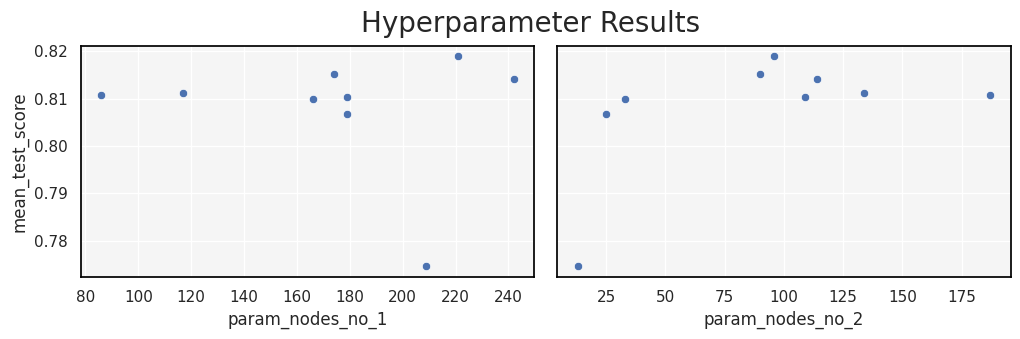

In [ ]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space, axs.ravel())):
    sns.scatterplot(
        data=results_df,
        x="param_" + param_category,
        y="mean_test_score",
        ax=ax,
    )

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Hyperparameter Results", y=1.0, fontsize=20);

# Section  5 - Final Model and Results

In [ ]:
# Generating the final model using the best hyperparameters

final_model = create_model_function(**best_params)

h = final_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS_NO,
    batch_size=BATCH_SIZE_NO,
    validation_data=(X_test, y_test),
    verbose=0,
)

final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 221)           13039     
                                                                 
 gru (GRU)                   (None, 20, 96)            91872     
                                                                 
 gru_1 (GRU)                 (None, 96)                55872     
                                                                 
 dense (Dense)               (None, 96)                9312      
                                                                 
 dense_1 (Dense)             (None, 18)                1746      
                                                                 
Total params: 171841 (671.25 KB)
Trainable params: 171841 (671.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


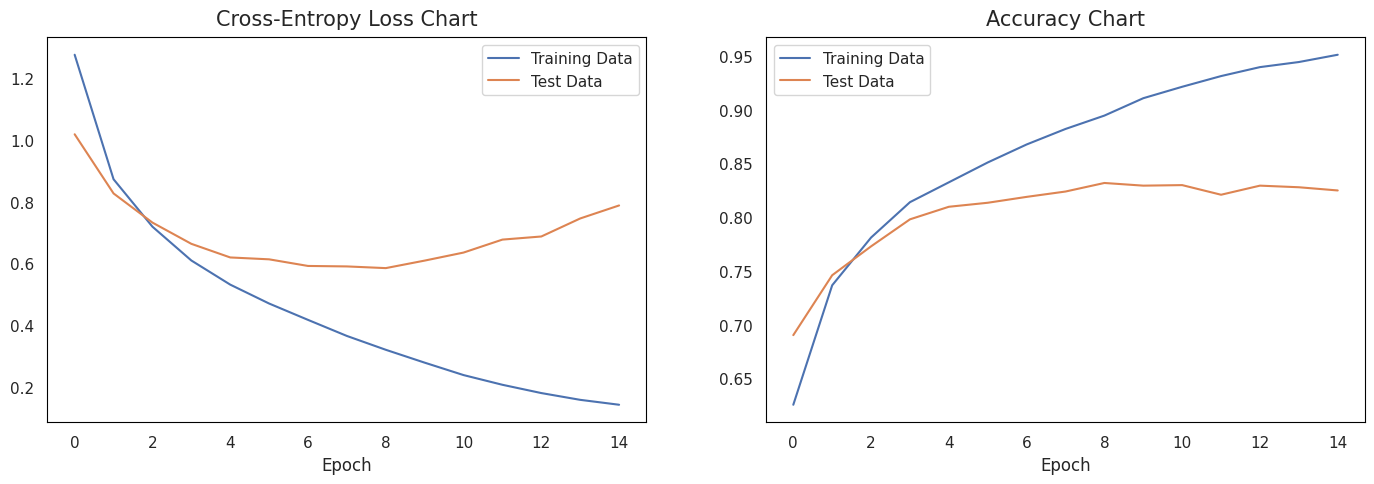

In [ ]:
# Plotting the model metrics and scoring for each epoch during training (test set)

sns.set_theme(
    rc={
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=1,
)

fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(h.history["loss"], label="Training Data")
ax[0].plot(h.history["val_loss"], label="Test Data")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Cross-Entropy Loss Chart", y=1.01, fontsize=15)
ax[0].legend()

ax[1].plot(h.history["categorical_accuracy"], label="Training Data")
ax[1].plot(h.history["val_categorical_accuracy"], label="Test Data")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy Chart", y=1.01, fontsize=15)
ax[1].legend();

In [ ]:
# Displaying the final model metrics and scoring on the test set

test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print(
    f"""
Test Set Cross-Entropy Loss: {test_loss:0.3f}
Test Set Accuracy Score: {test_accuracy:0.3f}
"""
)

126/126 [==============================] - 1s 4ms/step - loss: 0.7875 - categorical_accuracy: 0.8249

Test Set Cross-Entropy Loss: 0.787
Test Set Accuracy Score: 0.825



In [ ]:
# Function generated to use model and make predictions

# Creates a dictionary of the origins with the token values as the keys
origins_dictionary = dict(
    [(token, origin) for (origin, token) in tokenizer_origins.word_index.items()]
)

def predict_origin_function(name: str):
    assert isinstance(name, str)

    # Converts name into padded sequence of tokens
    sequenced_name = tokenizer_names.texts_to_sequences([name])
    x_name = np.array(pad_sequences(sequenced_name, maxlen=max_name_length))

    y_output = final_model.predict(x_name)
    # Finding the vector index with the highest probability, then index + 1 used to return the corresponding token value, which is the key used in the origins dictionary
    y_origin = origins_dictionary[np.argmax(y_output) + 1]
    return y_origin

In [ ]:
# Displaying prediction outputs for two names using the function
print(
    f"""
Origin prediction for the name James: {predict_origin_function("James")}
Origin prediction for the name Evva: {predict_origin_function("Evva")}
"""
)

1/1 [==============================] - 0s 18ms/step

Origin prediction for the name James: english
Origin prediction for the name Evva: russian

